In [1]:
import pandas as pd
import numpy as np
from typing import List, Tuple, TypeVar, Union
import matplotlib.pyplot as plt
import seaborn as sns

### Data: basic overview

In [2]:
data = pd.read_parquet('datasets/data.parquet')
labels = pd.read_csv('datasets/labels.csv')

In [3]:
def check_constant_and_nan(df: pd.DataFrame) -> Tuple[List[str], List[str]]:
    """
    This function checks a pandas DataFrame for columns that consist 
    only of one unique value (constants) and columns that consist only of NaN values. 
    It prints the names of such columns and returns them in two separate lists.

    Parameters:
    df (pd.DataFrame): The pandas DataFrame to check.

    Returns:
    constant_cols (list of str): A list of column names that consist only of one unique value.
    nan_cols (list of str): A list of column names that consist only of NaN values.
    """
    # Check the uniqueness and presence of all NaN values
    is_constant = df.nunique() == 1
    is_nan = df.isnull().all()

    # Get column names
    constant_cols = is_constant[is_constant].index.tolist()
    nan_cols = is_nan[is_nan].index.tolist()

    if constant_cols:
        print(f'Columns consisting of only one value: {constant_cols}')
    else:
        print('No columns consisting of only one value.')

    if nan_cols:
        print(f'Columns consisting only of NaN values: {nan_cols}')
    else:
        print('No columns consisting only of NaN values.')
    
    return constant_cols, nan_cols


print('Check columns for "data" dataset')
check_constant_and_nan(data)
print()
print('Check columns for "labels" dataset')
check_constant_and_nan(labels)

Check columns for "data" dataset
No columns consisting of only one value.
No columns consisting only of NaN values.

Check columns for "labels" dataset
No columns consisting of only one value.
No columns consisting only of NaN values.


([], [])

### Missing values

Some values are missing, but pandas reports that none are missing. It may happen that the missing values are not coded correctly, and instead of NaN there will be values such as question mark `?`, a dash `'-'`, `'unknown'/Unknown'`, `'missing'/Missing'` or `'NA'/'N/A'` will be given.
In this case I replace any errors when filling the dataset with np.nan.

In [4]:
def replace_values_with_nan(dataset: pd.DataFrame, values_to_replace: List[str]) -> pd.DataFrame:
    """
    Replace specific values in a pandas DataFrame with NaN.

    The function first converts all string values in the DataFrame to lower case 
    and then replaces the specified values with NaN.

    Parameters:
    dataset (pd.DataFrame): The input DataFrame.
    values_to_replace (List[str]): The list of string values to be replaced with NaN.

    Returns:
    pd.DataFrame: The DataFrame with specified values replaced by NaN.
    """

    dataset = dataset.applymap(lambda x: x.lower() if type(x) == str else x)
    dataset = dataset.replace(values_to_replace, np.nan)
    return dataset

values_to_replace = ['?', '-', 'unknown', 'missing', 'na', 'n/a']
data = replace_values_with_nan(data, values_to_replace)
labels = replace_values_with_nan(labels, values_to_replace)

In [5]:
def count_missing_values(df: pd.DataFrame) -> pd.Series:
    """
    Count the number of missing values in each column of a pandas DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    pd.Series: A Series that contains the number of missing values in each column.
    """
    missing_values = df.isnull().sum()
    return missing_values

print('Check for missing values for "data" dataset')
print(count_missing_values(data))
print()
print('Check for missing values for "labels" dataset')
print(count_missing_values(labels))

Check for missing values for "data" dataset
MachineId        0
MeasurementId    0
Pressure         0
dtype: int64

Check for missing values for "labels" dataset
MachineId           0
MeasurementId       0
PumpFailed        485
SlowStart        8085
SlowEnd          8085
dtype: int64


I see that the target in the `labels` dataset that we need to predict contains missing values. I will delete these lines.

In [6]:
labels = labels.dropna(subset=['PumpFailed'])

### Imputing missing values for `SlowStart` and `SlowEnd`
I did not substitute missing values in these features, since the probability that I will put True or False correctly is equal to the probability of flipping a coin. 
When building the models, I will see how the models will behave with nan values and if I replace the missing values with -9999. (While with XGBoost the model can handle nan, with Logistic Regression I will replace the missing values because the model cannot handle nan).

In [7]:
data.head()

,MachineId,MeasurementId,Pressure
0,0_0_0,0,0.0
1,0_0_0,0,0.0
2,0_0_0,0,0.0
3,0_0_0,0,0.0
4,0_0_0,0,0.0


In [8]:
data.shape

(18466364, 3)

In [9]:
data.nunique()

MachineId           556
MeasurementId      8836
Pressure         386064
dtype: int64

### Generate plots of air pressure over time for three randomly selected machines
The purpose is to visually identify any patterns in the air pressure, such as sudden drops or slow increases, that could indicate a pump failure. 
* Each plot represents a single machine's cycle, with the X-axis denoting time (as a sequence of measurements) and the Y-axis denoting air pressure.

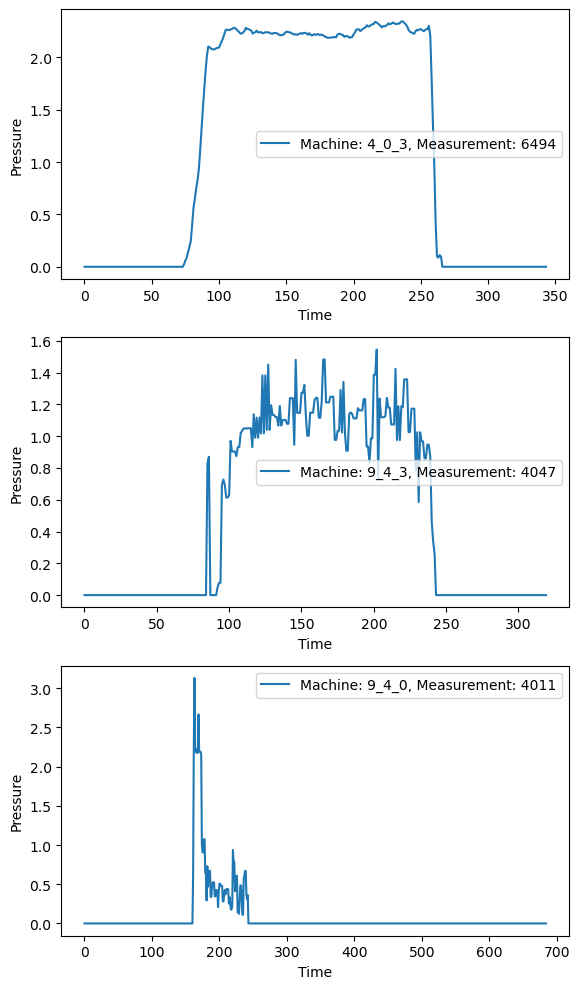

In [10]:
random_machines = data[['MachineId', 'MeasurementId']].drop_duplicates().sample(3)

fig, axes = plt.subplots(3, 1, figsize=(6, 10))

for i, (index, row) in enumerate(random_machines.iterrows()):
    machine_id = row['MachineId']
    measurement_id = row['MeasurementId']
    
    # Select the data for the machine and measurement
    subset = data[(data['MachineId'] == machine_id) & (data['MeasurementId'] == measurement_id)]
    
    axes[i].plot(np.arange(len(subset)), subset['Pressure'], label=f'Machine: {machine_id}, Measurement: {measurement_id}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Pressure')
    axes[i].legend()

plt.tight_layout()
plt.show()

### Outliers detection
I decided not to process outliers because it may not be a dataset filling error, but a real machine failure. I would ask my colleagues for advice before working with outliers.

In [11]:
labels.head()

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd
0,0_0_0,0,False,False,False
2,0_0_2,0,False,False,False
3,0_0_3,0,True,False,False
5,0_1_1,1,True,False,False
8,1_0_0,2,False,True,False


In [12]:
labels.shape

(26900, 5)

In [13]:
labels.nunique()

MachineId         374
MeasurementId    8835
PumpFailed          2
SlowStart           2
SlowEnd             2
dtype: int64

### Feature engineering

In [14]:
T = TypeVar('T', bound='pd.core.series.Series')

def calculate_features(group: pd.DataFrame) -> T:
    """
    This function calculates several features based on the 'Pressure' column of the provided DataFrame.
    Features are calculated separately for the first and second half of the data.

    Parameters:
    group (pd.DataFrame): The DataFrame to calculate the features from. 
                          It should contain a 'Pressure' column.

    Returns:
    features (pd.Series): A Series object with the calculated features.
    """
    
    # Determine the size of the first half of the cycle
    half_cycle_size = len(group) // 2
    first_half = group.iloc[:half_cycle_size]
    
    # Calculate the statistics for the first half of the cycle
    mean_pressure_first_half = first_half['Pressure'].mean()
    median_pressure_first_half = first_half['Pressure'].median()
    std_pressure_first_half = first_half['Pressure'].std()
    max_pressure_first_half = first_half['Pressure'].max()
    
    # Calculate the maximum difference between two consecutive observations in the first half
    max_diff_first_half = first_half['Pressure'].diff().abs().max()
    
    # Separate the second half of the cycle
    second_half = group.iloc[half_cycle_size:]
    
    mean_pressure_second_half = second_half['Pressure'].mean()
    median_pressure_second_half = second_half['Pressure'].median()
    max_pressure_second_half = second_half['Pressure'].max()
    std_pressure_second_half = second_half['Pressure'].std()
    
    max_diff_second_half = second_half['Pressure'].diff().abs().max()
    
    return pd.Series({
        'mean_pressure_first_half': mean_pressure_first_half,
        'median_pressure_first_half': median_pressure_first_half,
        'std_pressure_first_half': std_pressure_first_half,
        'max_pressure_first_half': max_pressure_first_half,
        'max_diff_first_half': max_diff_first_half,
        'mean_pressure_second_half': mean_pressure_second_half,
        'median_pressure_second_half': median_pressure_second_half,
        'max_pressure_second_half': max_pressure_second_half,
        'std_pressure_second_half': std_pressure_second_half,
        'max_diff_second_half': max_diff_second_half
    })
grouped_data = data.groupby(['MachineId', 'MeasurementId']).apply(calculate_features).reset_index()

In [15]:
grouped_data.head()

,MachineId,MeasurementId,mean_pressure_first_half,median_pressure_first_half,std_pressure_first_half,max_pressure_first_half,max_diff_first_half,mean_pressure_second_half,median_pressure_second_half,max_pressure_second_half,std_pressure_second_half,max_diff_second_half
0,0_0_0,-1,0.230289,0.000000,0.415121,2.439888,2.172414,0.187364,0.000000,2.143523,0.380598,1.915191
1,0_0_0,0,0.605873,0.864078,0.582492,1.584466,0.720388,0.144275,0.000000,1.449515,0.355725,0.590291
2,0_0_0,215,0.710727,0.435973,0.729057,1.838710,0.677419,0.000000,0.000000,0.000000,0.000000,0.000000
3,0_0_0,237,0.977540,1.337876,0.706656,1.927632,1.081767,0.023251,0.000000,0.575188,0.088071,0.218985
4,0_0_0,353,0.344599,0.000000,0.390084,1.186589,0.455782,0.615127,0.755102,1.275996,0.381526,0.677357


In [16]:
grouped_data.shape

(27385, 12)

### Merge two datasets

In [17]:
df = pd.merge(labels, grouped_data, on=['MachineId', 'MeasurementId'])

In [18]:
df.head()

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd,mean_pressure_first_half,median_pressure_first_half,std_pressure_first_half,max_pressure_first_half,max_diff_first_half,mean_pressure_second_half,median_pressure_second_half,max_pressure_second_half,std_pressure_second_half,max_diff_second_half
0,0_0_0,0,False,False,False,0.605873,0.864078,0.582492,1.584466,0.720388,0.144275,0.000000,1.449515,0.355725,0.590291
1,0_0_2,0,False,False,False,0.444347,0.625709,0.425363,1.205104,0.435728,0.443484,0.613422,1.132325,0.440333,0.615312
2,0_0_3,0,True,False,False,0.588216,0.918919,0.541255,1.410603,0.426195,0.324494,0.000000,1.497921,0.503955,0.753638
3,0_1_1,1,True,False,False,0.509806,0.443299,0.525591,1.470103,0.646392,0.358250,0.000000,1.440206,0.520885,0.703093
4,1_0_0,2,False,True,False,0.514324,0.180529,0.547093,1.462193,0.240076,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
df.shape

(26900, 15)

### Check for correct merge

In [20]:
df_filtered = df[df['MachineId'] == '0_0_0']
df_filtered.head()

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd,mean_pressure_first_half,median_pressure_first_half,std_pressure_first_half,max_pressure_first_half,max_diff_first_half,mean_pressure_second_half,median_pressure_second_half,max_pressure_second_half,std_pressure_second_half,max_diff_second_half
0,0_0_0,0,False,False,False,0.605873,0.864078,0.582492,1.584466,0.720388,0.144275,0.000000,1.449515,0.355725,0.590291
492,0_0_0,215,False,False,False,0.710727,0.435973,0.729057,1.838710,0.677419,0.000000,0.000000,0.000000,0.000000,0.000000
550,0_0_0,237,False,False,True,0.977540,1.337876,0.706656,1.927632,1.081767,0.023251,0.000000,0.575188,0.088071,0.218985
760,0_0_0,353,False,False,False,0.344599,0.000000,0.390084,1.186589,0.455782,0.615127,0.755102,1.275996,0.381526,0.677357
889,0_0_0,411,True,False,False,0.642032,0.325942,0.671804,1.922395,0.937916,0.334752,0.000000,1.637472,0.513144,1.070953


In [21]:
df_filtered.shape

(569, 15)

In [22]:
df_filtered['MeasurementId'].nunique()

569

### Replace bool values to 1 and 0
Most machine learning algorithms, including linear regression, decision trees, work with numerical data. Therefore, Boolean values are usually converted to numeric values before being used in these models.

In [23]:
df = df.replace({True: 1, False: 0})

In [24]:
print('Dataset contains these types of features:', list(df.dtypes.unique()))

Dataset contains these types of features: [dtype('O'), dtype('int64'), dtype('float64')]


### One-Hot Encoder
Though label encoding is straight but it has the disadvantage that the numeric values can be misinterpreted by algorithms as having some sort of hierarchy/order in them. This ordering issue is addressed in another common alternative approach called ‘One-Hot Encoding’. In this strategy, each category value is converted into a new column and assigned a 1 or 0 (notation for true/false) value to the column.

In [25]:
# Apply one-hot encoding to 'MachineId' column
df = pd.get_dummies(df, columns=['MachineId'])

Check that changes in the dataset have not resulted in constants and columns with completely missing values.

In [26]:
print('Check columns for "df" dataset')
check_constant_and_nan(df)

Check columns for "df" dataset
No columns consisting of only one value.
No columns consisting only of NaN values.


([], [])

In [27]:
df.shape

(26900, 388)

In [28]:
print('Dataset contains these types of features:', list(df.dtypes.unique()))

Dataset contains these types of features: [dtype('int64'), dtype('float64'), dtype('uint8')]


### Сlass balance check

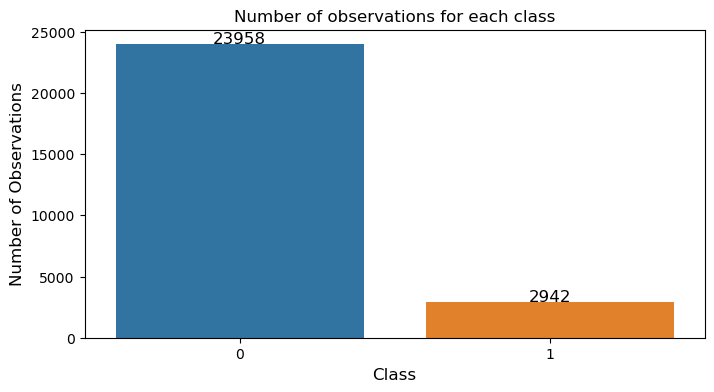

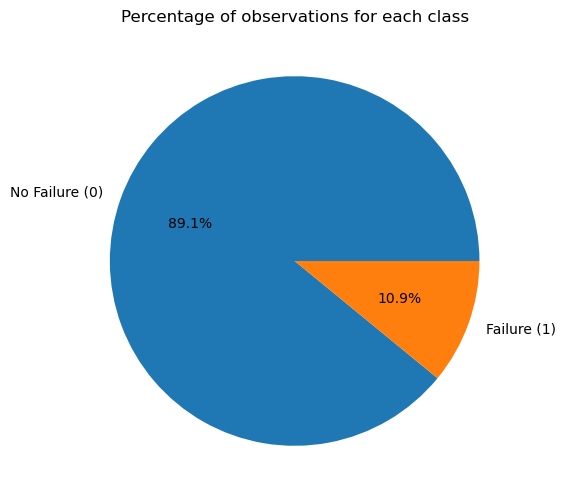

In [29]:
class_counts = df['PumpFailed'].value_counts()

# Graph to show the number of observations for each class
plt.figure(figsize=(8,4))
bar_plot = sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Number of observations for each class')
plt.ylabel('Number of Observations', fontsize=12)
plt.xlabel('Class', fontsize=12)

for i, v in enumerate(class_counts.values):
    bar_plot.text(i, v + 50, str(v), horizontalalignment='center', fontsize=12)

plt.show()

# Pie chart to display class percentages
plt.figure(figsize=(6,6))
plt.pie(class_counts, labels = ['No Failure (0)', 'Failure (1)'], autopct='%1.1f%%')
plt.title('Percentage of observations for each class')
plt.show()

I can see that the dataset is unbalanced, when building the models further I will check how they will cope with an unbalanced dataset and with a balanced one. 

### Save preprocessed dataset

In [30]:
df.to_csv('datasets/processed_dataset.csv')
df.to_csv('datasets/processed_dataset.zip', index=False, compression='zip')